### Narrative analytics and experimentation



### An A/B experimenting in home resales

Cobb County Realtors is a long established traditional real estate firm that has ventured into the direct reselling of homes.  This process includes purchasing the home directly from the sellers, making any necessary repairs /  improvements, listing the home for sale, staging the home, maintaining the home while it is on the market and possibly acting as the buyer’s agent during the sale.  While this business change has lead to greatly increased revenues and more importantly profits, a whole new category of operational has also been introduced. Cobb County Realtors needs a new business tactics for this new business venture.  

While in some ways inexperienced,  our realtor has been afforded a great opportunity to do some A/B experimentation.  A metric that directly affects their profitability is the “Days on Market” for home sales.   “Days on Market” (DOM)  is therefore directly related to costs such as maintenance and interest payments on the credit balance needed to purchase their homes.  A reduction in the average DOM for their home sales should reduce costs and therefore increase profits.


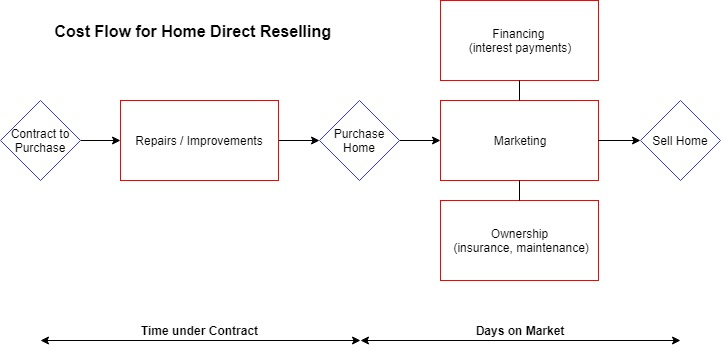

The marketing process includes listing the home, adding a page to our website, staging with furnishings, printing flyers, providing warm cookies and hosting open houses.  Currently our agents host open houses on the weekends.  


**Hypothesis:**  Hosting open houses reduces the home sales costs by significantly reducing the “Days on Market” and the associated maintenance and marketing costs.  


The **two versions** will for this experiment:
A is the “already in use” marketing effort that includes hosting open houses.  
B is our marketing effort without hosting open houses.  

The **sample** is the homes that Cobb County Real Estate purchases for resale for one year.  For the testing duration they will be split 50% / 50% between version A and version B.   

All home sales data will include these features.  With respect to the DOM metric significant home attributes are : 
Major attributes - *location, price, condition, trendy, curb appeal*
Minor attributes - any other feature

To some degree our sample has already been controlled with respect to the DOM features as only “qualifying” homes are purchased. Based upon the fact that costs are associated with DOM duration, *location* is limited areas with past quicker sales experience.  Our qualifying *price* range is slotted in the same manner.  *Condition* and *curb appeal* are normalized by the repairs / improvements phase of our business process.  *Trendy* are popular home features that buyers covet that have been proven to be statistically significant with respect to DOM reduction .  This will be the most difficult feature to account for in our experiment.


**Outcome of interest:**  The “Days on Market” metric will be measured for both versions.  Every sale will be classified by our standard home sales feature with emphasis on the major attributes above.  

As “Time of Year” ( identified by Month) has significant impact on DOM, our analysis and rollout plan will need to account for it.    


**Other measured variables** include:.  Any associated price reduction will be analyzed against our home sales DOM statistic.  The negotiations are done by a single individual, but will be analyzed for bias between the two versions.    

In [6]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats

In [190]:
# data from zillow 
doz = {'file':'DaysOnZillow.txt',    'shape':(1012, 116),  'name':'Days on Zillow'}
nls = {'file':'MonthlyListings.txt', 'shape':(2008, 81),   'name':'New Listings'}
stl = {'file':'SaleToList.txt',      'shape':(11252, 116), 'name':'Ratio of Sales to Listings'}

In [8]:
# using zillow data for 5 metro atlanta counties
regions = ['Fulton County','Gwinnett County','Dekalb County','Cobb County','Cherokee County']
labels =  [region.split()[0].lower() for region in regions]

# process zillow one variable csv files into dfs for plotting
# parameter dicts are zillow file attributes
def zillows_dfs(dict):  
    dict['xlabel'] = 'Months'
    # dfs with labels 	fulton	gwinnett	dekalb	cobb	cherokee	date
    cols = [2] + [i for i in range(5,dict['shape'][1])]
    df = pd.read_csv(dict['file']) 
    df = df[(df.StateName == 'GA') & (df.RegionName.isin(regions))]
    df = df[df.columns[cols]]
    df = df.T[1:]
    df.columns = labels
    df = df.astype(float)
    df['date'] = [pd.Timestamp(x) for x in df.index]
    df.index = range(len(df))

    #df1's used for plots
    df1 = pd.concat([pd.DataFrame({'doz' : df[col], 'cty': pd.Series(np.repeat(col,len(df))), 'date' : df.date})
                    for col in df.columns if col != 'date'], axis=0)
    df1.index = range(len(df1))
    dict['df1'] = df1
    df['avg'] = np.around(df.mean(axis=1), decimals=2)
    df['mth'] = [pd.Timestamp(x).month for x in df.date]
    df['doy'] = [pd.Timestamp(x).dayofyear + 14 for x in df.date]
    dict['df'] = df
    
    
    gb = df[:-3].groupby('mth').mean()[['avg', 'doy']]    
    dict['gb'] = gb
    return dict


In [191]:
doz = zillows_dfs(doz)
nls = zillows_dfs(nls)

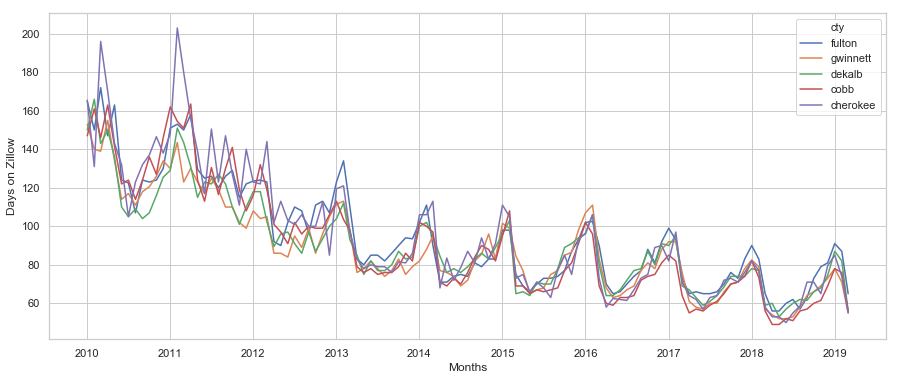

In [11]:
sns.set(style="whitegrid")
f, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(x='date', y='doz', data=doz['df1'], hue='cty', ax=ax)
ax.set(ylabel=doz['name'], xlabel=doz['xlabel'])
plt.show()

In [139]:
tabd = doz['df'][96:110][['avg','date']]
tabd.index = range(len(tabd))
tabd['xp'] = [(pd.Timestamp(x) - pd.Timestamp(tabd.iat[0,1])).days for x in tabd.date]
tabd.drop(['date'], inplace=True, axis=1)
tabd.columns = ['fp', 'xp']

In [197]:
tabp = nls['gb']
tabp.columns = ['fp', 'xp']
tabp.fp =  tabp.fp / tabp.fp.mean()

,fp,xp
mth,,
1,0.885989,15.000000
2,0.862150,46.000000
3,0.949425,74.166667
4,0.998089,105.166667
5,1.046713,135.166667
6,1.075477,166.166667
7,1.101619,196.166667
8,1.096548,227.166667
9,1.039099,258.166667


In [199]:
A = [i // 4 + 1 for i in range(day * 4 ) if  np.random.random() <= (prob * np.interp(i // 4 + 1, tabp.xp, tabp.fp, period=days) )]
data = pd.DataFrame(A, columns = ['day'])
data['id'] = [str(i).rjust(6,'0') for i in range(len(data))]
data['ntrp'] = data.day.apply(lambda x: int(np.round(np.interp(x, tabd.xp, tabd.fp, period=days),decimals = 0)))
data['dom']  = data.ntrp.apply(lambda x: int(np.round(np.random.chisquare(84),decimals=0)))
data.tail()

,day,id,ntrp,dom
518,362,000518,82,71
519,362,000519,82,79
520,363,000520,82,75
521,364,000521,83,100
522,365,000522,84,85


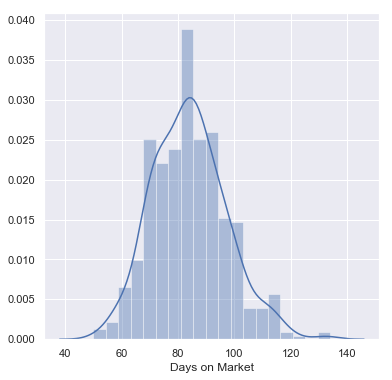

In [200]:
sns.set()
f, ax = plt.subplots(figsize=(6, 6))
sns.distplot(data.dom, color="b", ax=ax)
ax.set( xlabel='Days on Market')
plt.show()

In [168]:
# given for creating DOM population 
start = '2018-03-01'; end = '2019-03-01'; pur_year = 500
days = (pd.Timestamp(end)- pd.Timestamp(start)).days
prob = np.round(pur_year / (365 * 4), decimals = 2)
# create table to pull mean DOM from 
table = doz['df'][96:110][['avg','date']]
table.index = range(len(table))
table['fp'] = [(pd.Timestamp(x) - pd.Timestamp(table.iat[0,1])).days +14 for x in table.date]
table.drop(['date'], inplace=True, axis=1)
table.columns = ['xp', 'fp']
# array of home purchases up to four per day


In [107]:
purchases = np.where(np.random.uniform(size=(duration * 4)) <= p_pur, 1, 0)
#[purchase for purchase in purchases]    
    
    

In [ ]:
4959364017a